<a href="https://colab.research.google.com/github/iotanalytics/IoTTutorial/blob/main/code/preprocessing_and_decomposition/Multiscale_decomposation_with_1D_morphology_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Multiscale decomposition with 1D morphology analysis


## Introduction
Morphology decomposation is a time domain signal processing techniqeu. It can extract the shape of the wave.

Structuring element The basic idea in binary morphology is to probe an image with a simple, pre-defined shape, drawing conclusions on how this shape fits or misses the shapes in the image. This simple "probe" is called the structuring element, and is itself a binary image (i.e., a subset of the space or grid).

Basic operators The basic operations are shift-invariant (translation invariant) operators strongly related to Minkowski addition.

Let E be an Euclidean space or an integer grid, and A a binary image in E.

Erosion

The erosion of the dark-blue square by a disk, resulting in the light-blue square.

When the structuring element B has a center (e.g., B is a disk or a square), and this center is located on the origin of E, then the erosion of A by B can be understood as the locus of points reached by the center of B when B moves inside A. For example, the erosion of a square of side 10, centered at the origin, by a disc of radius 2, also centered at the origin, is a square of side 6 centered at the origin.

Example application: Assume we have received a fax of a dark photocopy. Everything looks like it was written with a pen that is bleeding. Erosion process will allow thicker lines to get skinny and detect the hole inside the letter "o".

Dilation

The dilation of the dark-blue square by a disk, resulting in the light-blue square with rounded corners.

If B has a center on the origin, as before, then the dilation of A by B can be understood as the locus of the points covered by B when the center of B moves inside A. In the above example, the dilation of the square of side 10 by the disk of radius 2 is a square of side 14, with rounded corners, centered at the origin. The radius of the rounded corners is 2.

Example application: dilation is the dual operation of the erosion. Figures that are very lightly drawn get thick when "dilated". Easiest way to describe it is to imagine the same fax/text is written with a thicker pen.

Opening

The opening of the dark-blue square by a disk, resulting in the light-blue square with round corners.

Example application: Let's assume someone has written a note on a non-soaking paper and that the writing looks as if it is growing tiny hairy roots all over. Opening essentially removes the outer tiny "hairline" leaks and restores the text. The side effect is that it rounds off things. The sharp edges start to disappear.

Closing

The closing of the dark-blue shape (union of two squares) by a disk, resulting in the union of the dark-blue shape and the light-blue areas.

Look detials at: https://en.wikipedia.org/wiki/Mathematical_morphology

## Code example

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [ ]:
## example data importing
data = pd.read_csv('https://raw.githubusercontent.com/iotanalytics/IoTTutorial/main/data/SCG_data.csv').drop('Unnamed: 0',1).to_numpy()[0,:1000]

In [ ]:
def structure_element(radius,types):
  #type: 0-line,1-circle,2-triangle
  se = np.zeros(radius*2+1)
  if types == 0:
    se = se + radius
  if types == 1:
    for i in range(radius*2+1):
      se[i]= np.sqrt(radius*radius-(radius-i)*(radius-i))
  if types == 2:
    for i in range(radius+1):
      se[i] = i;
      se[radius*2-i] = i;
  return se


def erosion(data,se):
  r = (len(se)-1)/2
  l = len(se)
  data = np.insert(data,0,data[0].repeat(r),0)
  data = np.append(data,data[-1].repeat(r))
  result = np.zeros(len(data)-len(se)+1)
  for i in range(len(data)-len(se)+1):
    result[i] = min(data[i:i+len(se)]-se)
  return result

def dilation(data,se):
  r = (len(se)-1)/2
  l = len(se)
  data = np.insert(data,0,data[0].repeat(r),0)
  data = np.append(data,data[-1].repeat(r))
  result = np.zeros(len(data)-len(se)+1)
  for i in range(len(data)-len(se)+1):
    result[i] = max(data[i:i+len(se)]+se)
  return result

def opening(data,se):
  data = erosion(data,se)
  data = dilation(data,se)
  return data

def closing(data,se):
  data = dilation(data,se)
  data = erosion(data,se)
  return data


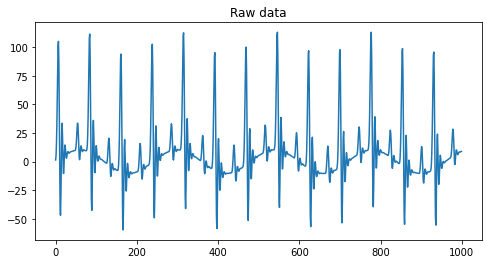

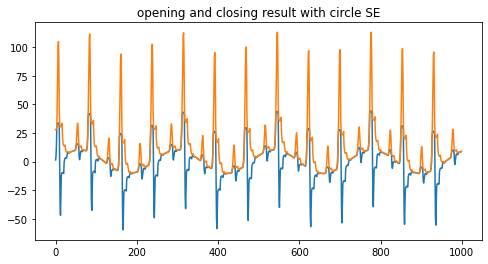

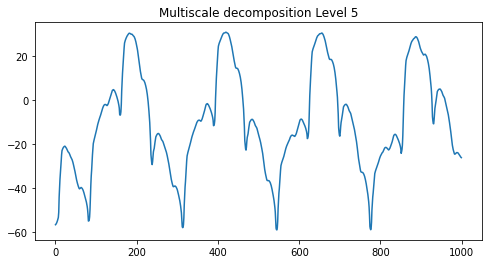

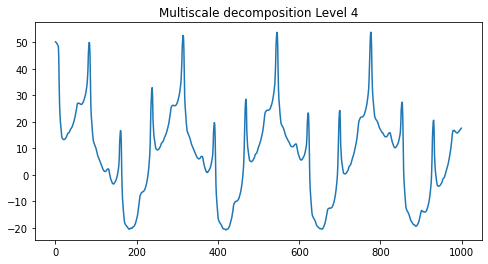

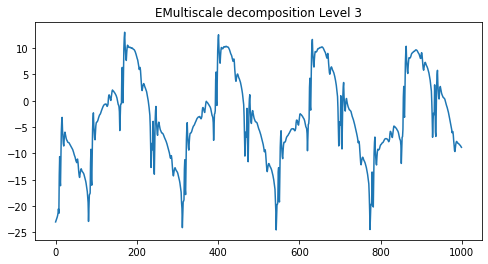

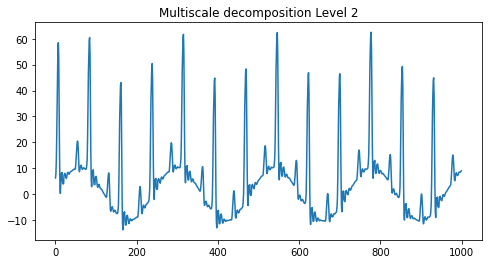

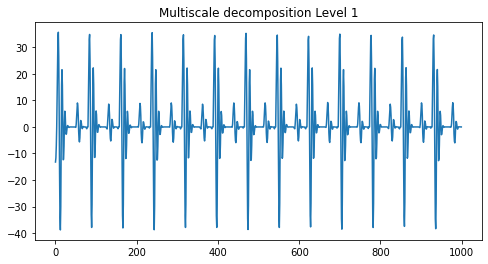

In [ ]:
## calculate opening and closing
def signal_opening_closing(data, radius, types):
  se = structure_element(radius=radius,types=types)
  opening_re = opening(data,se)
  closing_re = closing(data,se)

  return opening_re, closing_re

## calculate n order morphology decomposition
def morphology_decomposition(data, order=1, radius=[3]):
  assert len(radius) == order
  for i in range(order):
    cur_opening, cur_closing = signal_opening_closing(data, radius=radius[i], types=1)
    sin_extract = (cur_opening+cur_closing)/2
    if i == 0:
      data =  data - sin_extract
    else:
      data =  last_sin_extract - sin_extract
    last_sin_extract = np.copy(sin_extract)
  return data



## plot original data
plt.figure(figsize=(8,4))
plt.plot(data)
plt.title("Raw data")
plt.show()

opening_re, opening_closing = signal_opening_closing(data, radius=3, types=1)

## plot opening and closing data
plt.figure(figsize=(8,4))
plt.title("opening and closing result with circle SE")
plt.plot(opening_re)
plt.plot(opening_closing)
plt.show()


## calculate 
residual1 = morphology_decomposition(data, order=1, radius=[3])
residual2 = morphology_decomposition(data, order=2, radius=[3,7])
residual3 = morphology_decomposition(data, order=3, radius=[3,7,15])
residual4 = morphology_decomposition(data, order=4, radius=[3,7,15,15])
residual5 = morphology_decomposition(data, order=5, radius=[3,7,15,15,15])

plt.figure(figsize=(8,4))
plt.title("Multiscale decomposition Level 5")
plt.plot(residual5)
plt.show()

plt.figure(figsize=(8,4))
plt.title("Multiscale decomposition Level 4")
plt.plot(residual4)
plt.show()

plt.figure(figsize=(8,4))
plt.title("EMultiscale decomposition Level 3")
plt.plot(residual3)
plt.show()

plt.figure(figsize=(8,4))
plt.title("Multiscale decomposition Level 2")
plt.plot(residual2)
plt.show()


plt.figure(figsize=(8,4))
plt.title("Multiscale decomposition Level 1")
plt.plot(residual1)
plt.show()

## Discussion
Pros:

It is a pure time domain analysis without domain transform.

It is a signal shape analysis tool, which is sensitive to the upper or lower envalop of the signal on the given scale.

It has good performence to seperate the low frequency component of the signal.

The operater is simple and fast.

Cons:

It is not suitable for high frequency component analysis.

The output is rely on the choose of structuring element.